In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from casting.configuration import paths, columns, params, optimization
from casting.preprocessing import (
                                   drop_null, 
                                   split_by_dbscan,
                                   remove_outlier,
                                   save_scaler,
                                   save_label_encoding)
from casting.utils import load_data
from casting.optimizer import BayesianOptimizer

from casting.trainner import train_xgboost, train_lightgbm, train_extra_trees, train_tabnet, train_FTT, FttDataloader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


from torch.utils.data import DataLoader
import torch

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_columns', None) ## 모든 열을 출력한다

font_manager.fontManager.addfont('NanumGothic-Bold.ttf')
plt.rc('font', family='NanumGothic')

True
devece: cuda
torch version: 2.0.1+cu117


In [3]:
data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')
data = data_origin[columns.use_columns]

# Preprocessing

### base

In [4]:
## null 값 제외
data = drop_null(data).reset_index(drop=True)
## 이상치 제거
data = remove_outlier(data)


if params.model_name == 'FTT':
    ## 스케일러 생성
    save_scaler(data, 
                columns.numeric_columns, 
                columns.target_column,
                paths.X_scaler_path,
                paths.y_scaler_path
                )
    ## 카테고리 컬럼 처리를 위한 라벨 인코딩
    save_label_encoding(data, columns.category_columns, paths.label_encoding_path)

    split_by_dbscan(data, 'casting/data/scaled_data/')
else :
    ## 데이터 분리
    split_by_dbscan(data, 'casting/data/processed_data/')

# Predictor

### load_data

In [5]:
train, valid, test = load_data(params.model_name)

In [6]:
print(params.model_name)

EXT


### Modeling

In [7]:
## TODO : 모듈 형식으로 모델 GATEWAY 함수 구성
## TODO : AUTO ML 넣어서 제일 좋은 성능을 Select하는 형식

if params.model_name == 'LGBM' :
    model = train_lightgbm(train, valid)
elif params.model_name == 'XGB' :
    model = train_xgboost(train, valid)
elif params.model_name == 'EXT' :
    model = train_extra_trees(train, valid)
elif params.model_name == 'TABNET' :
    model = train_tabnet(train, valid)
## GPU 환경 필수
elif params.model_name == 'FTT' :
    model = train_FTT(train, valid)

### inference

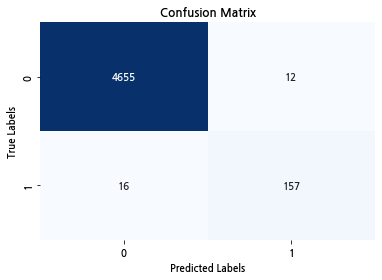

F1 Score: 0.9181
accuracy_score: 0.9942
precision_score: 0.9290
recall_score: 0.9075


In [8]:
# 혼동 행렬 계산

## FTT 모델일때 inference
if params.model_name == 'FTT' :
    test_data = FttDataloader(test)
    test_loader = DataLoader(test_data, batch_size=len(test), shuffle=False)

    model.to(device)
    model.eval()
    all_pred = []
    all_y = []
    x_samples = []
    with torch.no_grad():
        cul_loss = 0  # SE
        count = 0
        for batch, (x_categ, x_numer, y) in enumerate(test_loader):
            x_categ, x_numer, y = x_categ.to(device), x_numer.to(device), y.to(device)
            # 예측 오류 계산
            pred = model(x_categ, x_numer)
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            all_pred.extend(pred)
            all_y.extend(y)

    all_pred = np.array(all_pred)
    all_y = np.array(all_y)

    y_test = pd.DataFrame(np.array(all_y)) 
    y_pred = pd.DataFrame(np.array(all_pred)).round(1).astype(int)
## 그외 모델일때
else :

    X_test, y_test = test[columns.input_columns], test[columns.target_column]
    

    y_pred = model.predict(X_test.values)
    test_cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 계산
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 점수 계산
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

acc = accuracy_score(y_test, y_pred)
print(f'accuracy_score: {acc:.4f}')

ps = precision_score(y_test, y_pred)
print(f'precision_score: {ps:.4f}')

rs = recall_score(y_test, y_pred)
print(f'recall_score: {rs:.4f}')


# Postprocessing

## 유민님 작업 공간

# Optimizer

## Bayesian Optimization

In [12]:
# 최적화 실행
optimizer = BayesianOptimizer(model, optimization)
results = optimizer.optimize_batch(test.drop(columns.target_column, axis=1))

Optimizing parameters:   0%|          | 0/4840 [00:00<?, ?it/s]

|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 1         | -0.0      | 993.0     | 268.0     | 109.2     |
| 2         | -0.0      | 715.5     | 155.9     | 233.3     |
| 3         | -0.0      | 323.0     | 233.8     | 237.2     |
| 4         | -0.0      | 573.7     | 200.1     | 115.9     |
| 5         | -0.0      | 388.4     | 281.9     | 245.7     |
| 6         | -0.0      | 999.4     | 332.4     | 262.6     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 1         | -0.0      | 972.3     | 311.7     | 207.1     |
| 7         | -0.0      | 339.5     | 330.0     | 103.2     |
| 2         | -0.0      | 662.8     | 174.8     | 265.5     |
| 3         | -0.0      | 620.0     | 181.5     | 128.3     |
| 4         | -0.0      | 929.3     | 323.2     | 209.6     |
| 8         | -0.0      | 759.6     | 319.7     | 109.1     |
| 5     

Optimizing parameters:   0%|          | 1/4840 [00:03<4:24:53,  3.28s/it]

| 12        | -0.0      | 301.7     | 139.3     | 264.5     |
| 7         | -0.0      | 913.3     | 267.0     | 104.7     |
| 3         | -0.0      | 917.8     | 261.4     | 190.7     |
| 4         | -0.0      | 529.4     | 330.7     | 225.1     |
| 5         | -1.0      | 703.6     | 156.1     | 202.6     |
| 8         | -0.0      | 300.7     | 328.4     | 100.6     |
| 11        | -0.0      | 983.6     | 140.3     | 101.9     |
| 13        | -0.0      | 985.6     | 135.8     | 101.2     |
| 8         | -0.0      | 998.3     | 332.9     | 111.8     |
| 6         | -0.0      | 960.3     | 283.3     | 261.3     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 9         | -0.0      | 982.1     | 135.9     | 257.5     |
| 1         | -0.0      | 545.9     | 238.5     | 176.1     |
| 9         | -0.0      | 603.6     | 155.1     | 127.1     |
| 12        | -0.0      | 301.0     | 142.0     | 266.4     |
| 2     

Optimizing parameters:   0%|          | 2/4840 [00:04<3:03:58,  2.28s/it]

| 1         | -1.0      | 954.2     | 265.9     | 115.3     |
| 11        | -0.0      | 997.5     | 330.7     | 109.8     |
| 2         | -1.0      | 757.9     | 159.6     | 148.7     |
| 3         | -1.0      | 494.4     | 140.9     | 252.5     |
| 11        | -0.0      | 996.0     | 139.8     | 268.9     |
| 13        | -0.0      | 991.2     | 331.2     | 268.7     |
| 4         | -1.0      | 900.8     | 269.9     | 165.3     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 5         | -1.0      | 617.4     | 160.1     | 225.5     |
| 1         | -0.0      | 433.4     | 155.4     | 129.4     |
| 8         | -1.0      | 984.1     | 333.0     | 111.9     |
| 6         | -0.0      | 999.8     | 156.3     | 110.4     |
| 2         | -0.0      | 301.3     | 170.8     | 208.8     |
| 3         | -0.0      | 528.4     | 267.1     | 227.4     |
| 4         | -0.0      | 352.5     | 152.5     | 214.0     |
| 5     

Optimizing parameters:   0%|          | 3/4840 [00:06<2:32:25,  1.89s/it]

| 15        | -0.0      | 989.4     | 138.7     | 105.1     |
| 9         | -0.0      | 624.6     | 294.8     | 134.9     |
| 3         | -0.0      | 787.9     | 217.9     | 172.0     |
| 8         | -1.0      | 312.5     | 323.0     | 264.2     |
| 4         | -0.0      | 672.1     | 181.6     | 244.5     |
| 5         | -0.0      | 973.1     | 245.6     | 229.1     |
| 7         | -0.0      | 974.7     | 317.2     | 100.4     |
| 14        | -0.0      | 992.5     | 331.0     | 263.5     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 10        | -0.0      | 709.0     | 288.2     | 114.1     |
| 1         | -0.0      | 898.2     | 278.0     | 265.3     |
| 2         | -0.0      | 901.2     | 214.8     | 206.3     |
| 3         | -0.0      | 712.2     | 214.3     | 267.9     |
| 14        | -0.0      | 988.0     | 327.3     | 101.5     |
| 9         | -1.0      | 318.5     | 138.1     | 105.1     |
| 4     

Optimizing parameters:   0%|          | 4/4840 [00:07<1:57:44,  1.46s/it]

| 10        | -1.0      | 984.8     | 144.3     | 265.6     |
| 11        | -0.0      | 648.7     | 333.0     | 270.0     |
| 15        | -0.0      | 303.8     | 137.8     | 106.5     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------


Optimizing parameters:   0%|          | 5/4840 [00:07<1:21:12,  1.01s/it]

| 6         | -0.0      | 313.4     | 150.8     | 102.5     |
| 1         | -0.0      | 397.9     | 291.5     | 150.6     |
| 7         | -0.0      | 322.1     | 137.3     | 102.0     |
| 2         | -0.0      | 346.4     | 197.4     | 208.7     |
| 3         | -0.0      | 546.0     | 168.2     | 157.4     |
| 4         | -0.0      | 710.3     | 286.8     | 252.3     |
| 12        | -0.0      | 997.2     | 142.7     | 268.1     |
| 9         | -0.0      | 305.3     | 326.2     | 107.8     |
| 5         | -0.0      | 318.1     | 229.9     | 136.6     |
| 11        | -1.0      | 999.4     | 329.7     | 103.8     |
| 7         | -0.0      | 989.4     | 308.8     | 100.2     |
| 13        | -0.0      | 989.6     | 135.4     | 101.3     |
| 6         | -0.0      | 996.0     | 150.0     | 107.6     |
| 8         | -0.0      | 978.9     | 332.9     | 107.4     |
| 10        | -0.0      | 993.1     | 139.4     | 109.9     |
| 12        | -1.0      | 621.9     | 333.0     | 114.5     |
|   iter

Optimizing parameters:   0%|          | 6/4840 [00:09<2:00:15,  1.49s/it]

| 14        | -1.0      | 979.3     | 136.0     | 267.2     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 12        | -0.0      | 976.6     | 136.7     | 100.9     |
| 10        | -0.0      | 344.7     | 139.1     | 269.4     |
| 1         | -0.0      | 749.4     | 243.9     | 231.1     |
| 6         | -0.0      | 303.8     | 320.3     | 111.0     |
| 7         | -0.0      | 998.0     | 135.5     | 118.9     |
| 2         | -0.0      | 808.4     | 212.4     | 185.2     |
| 11        | -0.0      | 329.1     | 136.8     | 269.5     |
| 3         | -0.0      | 428.8     | 318.3     | 136.6     |
| 13        | -0.0      | 322.5     | 319.4     | 104.4     |
| 4         | -0.0      | 692.3     | 279.4     | 205.2     |
| 7         | -0.0      | 938.3     | 291.9     | 243.1     |
| 5         | -0.0      | 756.6     | 300.7     | 129.4     |
| 8         | -0.0      | 315.2     | 138.9     | 257.5     |
| 14    

Optimizing parameters:   0%|          | 8/4840 [00:10<1:21:38,  1.01s/it]

| 6         | -0.0      | 313.3     | 136.7     | 114.2     |
| 8         | -0.0      | 996.4     | 143.6     | 101.7     |
| 9         | -0.0      | 300.8     | 319.6     | 101.8     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 15        | -0.0      | 747.6     | 187.4     | 250.6     |


Optimizing parameters:   0%|          | 9/4840 [00:11<1:05:44,  1.22it/s]

| 1         | -0.0      | 695.4     | 267.8     | 167.3     |
| 15        | -0.0      | 306.4     | 138.1     | 267.6     |
| 12        | -0.0      | 310.2     | 327.4     | 105.4     |
| 2         | -0.0      | 972.8     | 136.6     | 131.6     |
| 13        | -0.0      | 984.4     | 140.2     | 102.5     |
| 3         | -0.0      | 741.1     | 237.2     | 140.8     |
| 4         | -0.0      | 694.3     | 218.7     | 256.2     |
| 5         | -0.0      | 941.9     | 199.2     | 218.7     |
| 9         | -0.0      | 304.0     | 147.0     | 268.7     |
| 7         | -0.0      | 999.4     | 151.1     | 107.3     |
| 10        | -0.0      | 301.3     | 139.1     | 100.7     |
| 14        | -0.0      | 994.1     | 326.4     | 261.9     |
| 13        | -0.0      | 303.6     | 151.8     | 268.3     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 1         | -0.0      | 708.2     | 163.9     | 221.8     |
| 6     

Optimizing parameters:   0%|          | 11/4840 [00:12<1:10:01,  1.15it/s]

| 9         | -0.0      | 309.8     | 323.0     | 105.7     |
| 13        | -0.0      | 971.3     | 331.8     | 262.3     |
| 8         | -0.0      | 637.5     | 231.7     | 173.4     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 12        | -0.0      | 320.7     | 139.5     | 267.9     |
| 1         | -0.0      | 904.8     | 157.7     | 125.7     |
| 2         | -0.0      | 660.7     | 217.7     | 193.9     |
| 11        | -0.0      | 991.8     | 139.4     | 105.1     |
| 3         | -0.0      | 782.5     | 172.3     | 187.3     |
| 9         | -0.0      | 647.9     | 170.3     | 213.0     |
| 4         | -0.0      | 526.6     | 161.6     | 257.4     |
| 7         | -0.0      | 339.0     | 137.6     | 268.9     |
| 5         | -0.0      | 965.3     | 194.7     | 117.4     |
| 10        | -0.0      | 305.8     | 139.3     | 264.1     |
| 13        | -0.0      | 309.6     | 136.9     | 109.4     |
| 14    

Optimizing parameters:   0%|          | 13/4840 [00:14<1:07:44,  1.19it/s]

| 1         | -0.0      | 635.8     | 327.9     | 105.8     |
| 6         | -0.0      | 854.9     | 152.8     | 178.2     |
| 9         | -0.0      | 301.0     | 328.2     | 101.7     |
| 8         | -0.0      | 957.0     | 332.3     | 268.0     |
| 2         | -0.0      | 594.7     | 227.3     | 208.3     |
| 15        | -0.0      | 983.2     | 136.9     | 262.1     |
| 13        | -0.0      | 994.0     | 332.3     | 264.7     |
| 3         | -0.0      | 836.6     | 303.8     | 244.7     |


Optimizing parameters:   0%|          | 14/4840 [00:14<57:57,  1.39it/s]  

| 12        | -0.0      | 304.7     | 330.3     | 113.3     |
| 13        | -0.0      | 984.2     | 320.2     | 268.9     |
| 4         | -0.0      | 669.0     | 279.7     | 125.4     |
| 5         | -0.0      | 490.1     | 174.0     | 220.7     |
| 10        | -0.0      | 308.3     | 138.1     | 265.2     |
| 7         | -0.0      | 993.6     | 329.3     | 137.9     |
| 14        | -0.0      | 995.2     | 138.0     | 268.9     |
| 13        | -0.0      | 983.5     | 135.1     | 105.9     |
| 9         | -0.0      | 314.3     | 138.8     | 267.4     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 11        | -0.0      | 887.0     | 309.8     | 126.4     |
| 1         | -0.0      | 954.3     | 180.2     | 215.9     |
| 6         | -0.0      | 990.7     | 135.8     | 105.1     |
| 14        | -0.0      | 987.7     | 143.1     | 264.5     |
| 2         | -0.0      | 816.9     | 157.7     | 208.0     |
| 10    

Optimizing parameters:   0%|          | 15/4840 [00:15<1:04:41,  1.24it/s]

| 11        | -0.0      | 970.3     | 332.4     | 263.1     |
| 5         | -0.0      | 355.4     | 183.7     | 170.4     |
| 1         | -0.0      | 721.8     | 197.9     | 153.3     |
| 12        | -0.0      | 302.8     | 136.5     | 103.3     |
| 15        | -0.0      | 303.8     | 326.0     | 268.3     |


Optimizing parameters:   0%|          | 16/4840 [00:16<54:02,  1.49it/s]  

| 7         | -0.0      | 302.8     | 136.6     | 130.1     |
| 2         | -0.0      | 580.6     | 231.8     | 173.3     |
| 3         | -0.0      | 783.4     | 147.8     | 124.1     |
| 4         | -0.0      | 576.1     | 140.8     | 268.2     |
| 5         | -0.0      | 310.2     | 317.8     | 207.6     |
| 9         | -0.0      | 303.3     | 320.0     | 102.0     |
| 12        | -0.0      | 302.6     | 320.7     | 264.9     |
| 15        | -0.0      | 998.2     | 139.2     | 269.6     |
| 6         | -0.0      | 344.0     | 332.9     | 269.2     |
| 13        | -0.0      | 320.6     | 329.2     | 268.4     |


Optimizing parameters:   0%|          | 17/4840 [00:16<46:03,  1.75it/s]

| 8         | -0.0      | 895.2     | 213.9     | 216.8     |
| 6         | -0.0      | 988.6     | 327.7     | 269.0     |
| 13        | -0.0      | 995.6     | 330.4     | 100.6     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 7         | -0.0      | 990.4     | 332.5     | 109.8     |
| 10        | -0.0      | 322.8     | 136.5     | 265.3     |
| 1         | -0.0      | 637.2     | 269.4     | 254.7     |
| 14        | -0.0      | 969.2     | 136.2     | 266.0     |
| 9         | -0.0      | 303.0     | 326.2     | 269.4     |
| 2         | -0.0      | 501.1     | 317.0     | 134.7     |
| 7         | -0.0      | 988.4     | 328.4     | 102.7     |
| 8         | -0.0      | 362.9     | 135.5     | 100.4     |
| 14        | -0.0      | 304.4     | 137.1     | 101.1     |
| 3         | -0.0      | 739.2     | 173.8     | 161.0     |
| 4         | -0.0      | 575.5     | 280.0     | 200.2     |
|   iter

Optimizing parameters:   0%|          | 18/4840 [00:17<54:11,  1.48it/s]

| 8         | -0.0      | 324.5     | 332.7     | 107.8     |
| 1         | -0.0      | 921.8     | 327.9     | 157.2     |
| 11        | -0.0      | 981.6     | 139.7     | 103.2     |
| 5         | -0.0      | 683.6     | 291.7     | 132.5     |
| 2         | -0.0      | 428.2     | 314.2     | 203.5     |
| 3         | -0.0      | 639.8     | 282.6     | 176.5     |
| 15        | -0.0      | 974.8     | 138.0     | 262.7     |


Optimizing parameters:   0%|          | 19/4840 [00:17<43:21,  1.85it/s]

| 10        | -0.0      | 998.1     | 136.5     | 262.7     |
| 9         | -0.0      | 995.3     | 146.4     | 268.3     |
| 4         | -0.0      | 788.2     | 244.4     | 213.8     |
| 5         | -0.0      | 905.4     | 221.2     | 206.8     |
| 12        | -0.0      | 506.1     | 288.6     | 243.1     |
| 6         | -0.0      | 311.2     | 138.6     | 104.6     |
| 9         | -0.0      | 995.3     | 138.9     | 104.7     |
| 11        | -0.0      | 948.5     | 328.6     | 105.5     |
| 6         | -1.0      | 316.0     | 140.2     | 105.1     |
| 7         | -0.0      | 994.1     | 146.6     | 102.6     |
| 13        | -0.0      | 990.4     | 330.0     | 267.1     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 10        | -0.0      | 998.9     | 325.5     | 103.8     |
| 12        | -0.0      | 300.1     | 135.8     | 108.2     |
| 7         | -0.0      | 784.2     | 248.7     | 213.7     |
| 10    

Optimizing parameters:   0%|          | 20/4840 [00:19<1:06:08,  1.21it/s]

| 1         | -0.0      | 729.2     | 283.0     | 189.5     |
| 14        | -0.0      | 989.5     | 137.2     | 265.5     |
| 12        | -0.0      | 993.0     | 326.8     | 260.6     |
| 6         | -0.0      | 304.8     | 326.6     | 269.7     |
| 2         | -0.0      | 519.8     | 331.5     | 133.7     |
| 8         | -1.0      | 1e+03     | 135.0     | 100.0     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 9         | -0.0      | 999.2     | 139.2     | 267.4     |
| 1         | -0.0      | 467.4     | 212.5     | 101.9     |
| 3         | -0.0      | 871.7     | 145.1     | 256.4     |
| 4         | -0.0      | 819.5     | 137.5     | 136.3     |
| 2         | -0.0      | 867.7     | 275.2     | 179.4     |
| 5         | -0.0      | 572.6     | 319.7     | 170.7     |
| 13        | -0.0      | 306.0     | 324.4     | 105.3     |
| 12        | -0.0      | 350.1     | 138.3     | 101.3     |
| 15    

Optimizing parameters:   0%|          | 21/4840 [00:19<58:47,  1.37it/s]  

| 3         | -0.0      | 743.0     | 268.8     | 216.1     |
| 4         | -0.0      | 307.5     | 329.4     | 104.8     |
| 9         | -0.0      | 911.8     | 333.0     | 270.0     |
| 10        | -0.0      | 966.7     | 331.7     | 263.3     |
| 5         | -0.0      | 859.6     | 230.3     | 120.3     |
| 7         | -0.0      | 981.4     | 327.8     | 103.9     |
| 6         | -0.0      | 302.9     | 136.7     | 248.1     |
| 14        | -0.0      | 992.7     | 140.7     | 265.1     |
| 13        | -0.0      | 973.3     | 142.3     | 270.0     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 11        | -0.0      | 310.5     | 331.8     | 267.0     |
| 1         | -0.0      | 399.7     | 224.7     | 215.6     |
| 6         | -0.0      | 309.6     | 137.5     | 269.7     |
| 2         | -0.0      | 881.0     | 266.8     | 243.6     |
| 3         | -0.0      | 440.4     | 313.6     | 178.3     |
|   iter

Optimizing parameters:   0%|          | 22/4840 [00:21<1:27:40,  1.09s/it]

| 3         | -0.0      | 708.9     | 158.1     | 126.7     |
| 4         | -0.0      | 628.0     | 219.5     | 138.4     |
| 7         | -0.0      | 305.5     | 142.8     | 105.3     |
| 5         | -0.0      | 704.7     | 233.0     | 188.9     |
| 9         | -0.0      | 304.4     | 150.4     | 107.3     |
| 9         | -0.0      | 988.3     | 150.4     | 267.3     |
| 15        | -0.0      | 884.7     | 149.8     | 252.8     |
| 6         | -0.0      | 984.2     | 331.6     | 269.6     |
| 10        | -0.0      | 993.5     | 331.6     | 269.6     |


Optimizing parameters:   0%|          | 24/4840 [00:22<55:52,  1.44it/s]  

| 10        | -0.0      | 997.8     | 331.8     | 257.6     |
| 8         | -0.0      | 998.1     | 141.8     | 102.3     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 12        | -0.0      | 300.0     | 333.0     | 270.0     |
| 10        | -0.0      | 307.2     | 322.6     | 266.0     |
| 7         | -0.0      | 305.1     | 158.5     | 263.5     |
| 11        | -0.0      | 994.8     | 136.1     | 100.5     |
| 1         | -0.0      | 530.4     | 187.3     | 255.5     |
| 11        | -0.0      | 923.3     | 330.0     | 167.3     |
| 2         | -0.0      | 726.2     | 212.5     | 234.1     |
| 7         | -0.0      | 324.2     | 332.2     | 100.8     |
| 3         | -0.0      | 625.5     | 328.3     | 253.5     |
| 4         | -0.0      | 779.7     | 235.1     | 240.6     |
| 5         | -0.0      | 488.9     | 318.4     | 193.2     |
| 9         | -0.0      | 693.4     | 331.9     | 104.5     |
| 12    

Optimizing parameters:   1%|          | 25/4840 [00:25<1:46:43,  1.33s/it]

| 15        | -0.0      | 319.9     | 324.6     | 101.4     |
| 5         | -0.0      | 336.4     | 288.8     | 198.2     |
| 12        | -0.0      | 999.9     | 136.1     | 104.5     |
| 12        | -0.0      | 993.3     | 137.0     | 257.8     |
| 8         | -0.0      | 944.4     | 332.6     | 102.3     |
| 10        | -0.0      | 327.3     | 136.1     | 263.6     |
| 6         | -0.0      | 998.3     | 162.3     | 265.9     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 9         | -0.0      | 991.7     | 145.9     | 269.1     |
| 1         | -0.0      | 342.3     | 317.3     | 235.2     |
| 13        | -0.0      | 310.4     | 138.1     | 269.3     |
| 2         | -0.0      | 743.3     | 204.0     | 239.8     |
| 7         | -0.0      | 999.0     | 146.0     | 269.4     |
| 13        | -0.0      | 300.3     | 139.5     | 261.8     |
| 13        | -0.0      | 301.5     | 332.7     | 269.8     |
| 3     

Optimizing parameters:   1%|          | 29/4840 [00:26<1:02:21,  1.29it/s]

| 15        | -0.0      | 336.4     | 332.8     | 100.0     |
| 12        | -0.0      | 314.3     | 141.9     | 100.0     |


Optimizing parameters:   1%|          | 30/4840 [00:26<53:42,  1.49it/s]  

| 10        | -0.0      | 720.7     | 324.1     | 267.1     |
| 2         | -0.0      | 886.4     | 214.0     | 243.2     |
| 11        | -0.0      | 306.6     | 139.0     | 101.5     |
| 15        | -0.0      | 992.8     | 325.7     | 100.2     |


Optimizing parameters:   1%|          | 31/4840 [00:27<46:31,  1.72it/s]

| 3         | -0.0      | 983.9     | 219.7     | 165.5     |
| 4         | -0.0      | 911.8     | 162.6     | 205.2     |
| 7         | -0.0      | 321.6     | 137.8     | 102.0     |
| 9         | -0.0      | 311.1     | 141.4     | 102.5     |
| 5         | -0.0      | 802.2     | 226.5     | 137.9     |
| 12        | -0.0      | 999.7     | 322.5     | 110.4     |
| 11        | -0.0      | 317.3     | 135.9     | 269.5     |
| 6         | -0.0      | 302.4     | 145.8     | 249.0     |
| 13        | -0.0      | 304.9     | 326.3     | 267.8     |
| 8         | -0.0      | 996.3     | 136.0     | 102.1     |
| 10        | -0.0      | 977.2     | 138.0     | 267.6     |
|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 1         | -0.0      | 611.5     | 164.6     | 183.0     |
| 2         | -0.0      | 797.4     | 149.5     | 258.8     |
| 3         | -0.0      | 487.7     | 189.5     | 218.5     |
| 12    

Optimizing parameters:   1%|          | 31/4840 [00:28<1:13:12,  1.09it/s]

|   iter    |  target   | cast_p... | lower_... | upper_... |
-------------------------------------------------------------
| 1         | -0.0      | 807.6     | 250.8     | 110.0     |
| 2         | -0.0      | 980.5     | 328.4     | 126.9     |
| 9         | -0.0      | 310.3     | 328.4     | 107.0     |
| 3         | -0.0      | 893.0     | 139.2     | 222.5     |
| 15        | -0.0      | 997.4     | 326.8     | 268.8     |
| 4         | -0.0      | 446.3     | 200.2     | 253.2     |
| 5         | -0.0      | 523.1     | 315.3     | 124.9     |


| 6         | -0.0      | 999.5     | 305.6     | 102.2     |
| 14        | -0.0      | 987.8     | 139.0     | 109.1     |


KeyboardInterrupt: 

In [17]:
## 최적화 결과 비교

X_test_origin, y_test = test[columns.input_columns], test[columns.target_column]
X_test = X_test_origin.copy()

X_test['lower_mold_temp2'] = optimizer.max['params']['lower_mold_temp2']
X_test['cast_pressure'] = optimizer.max['params']['cast_pressure']
X_test['molten_temp'] = optimizer.max['params']['molten_temp']


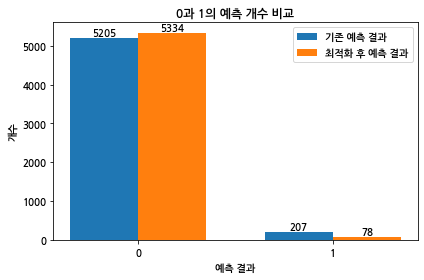

In [18]:
# 예측 결과 생성
pred_origin = model.predict(X_test_origin)  # 기존 예측 결과
pred_test = model.predict(X_test)  # 새로운 예측 결과

# 각 예측 결과에서 0과 1의 개수 계산
count_origin = [np.sum(pred_origin == 0), np.sum(pred_origin == 1)]
count_test = [np.sum(pred_test == 0), np.sum(pred_test == 1)]

# 막대 그래프 데이터 준비
labels = ['0', '1']
x = np.arange(len(labels))  # x축 위치

# 그래프 그리기
width = 0.35  # 막대 너비

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, count_origin, width, label='기존 예측 결과')
bars2 = ax.bar(x + width/2, count_test, width, label='최적화 후 예측 결과')

# 라벨 추가
ax.set_xlabel('예측 결과')
ax.set_ylabel('개수')
ax.set_title('0과 1의 예측 개수 비교')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 각 막대에 값 표시
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Optimizer 사후 분석